Steady state heat equation
======

This notebook is intended to give a quick overview of how to run underworld using ipython notebooks. It is the beginning of a series of tutorials which will increase in functionality. By the end of these tutorials the user should be able to tackle the more complex notebooks available in the **publications** directory.

**This lesson introduces the concepts of:**
1. Basics of underworld.
2. Setting up the mesh.
4. Setting boundary conditions.
5. Solving.
6. Plotting physical quantities on the mesh.

**Keywords:** initial conditions, boundary conditions, heat equation, mesh basics

In [1]:
import underworld as uw
from underworld import function as fn
import glucifer.pylab as plt

Setup parameters
-----

Set physical values for test. Particularly the number of dimensions for the simulation (*dim*), simulation resolution (*res*) and simulation box height and lengths.

In [2]:
# Set number of dimensions.
dim = 2
# Set simulation box size.
boxHeight = 1.0
boxLength = 2.0
# Set min/max temperatures.
tempMin = 0.0
tempMax = 1.0
# Set the resolution.
res = 4

Create mesh and finite element variables
------

Create mesh objects. These store the indices and spatial coordiates of the grid points on the mesh.

In [3]:
elementMesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                         elementRes = (res, res), 
                                           minCoord = (0., 0.), 
                                           maxCoord = (boxLength, boxHeight))
# The temperature field uses the element mesh.
temperatureMesh = elementMesh

More information on meshes can be found in the user guide.

Create Finite Element (FE) variables for the temperature field. This is a scalar fields so it only needs one value at each mesh point.

In [4]:
temperatureField = uw.fevariable.FeVariable( feMesh=temperatureMesh, nodeDofCount=1 )

Initialise data.

In [5]:
temperatureField.data[:] = 0.

Set boundary conditions
----------

First we need to decide where the boundary conditions should be applied. Underworld includes functions for listing special sets of vertices on the mesh. To see the list of them run the following command.

In [6]:
temperatureMesh.specialSets.keys()

['MaxI_VertexSet',
 'MinI_VertexSet',
 'AllWalls',
 'AllWalls_VertexSet',
 'MinJ_VertexSet',
 'MaxJ_VertexSet',
 'Empty']

We wish to set the temperature at the bottom of the domain to have the maximum temperature, and the temperature across the top to have the minimum temperature. 

Note that by convention, where the mesh has a resolution (I,J), we consider that I is the resolution is in the x direction and J is the resolution in the y direction. The vertices across the bottom of the domain are therefore contained within minimum 'J' set, and those across the top are in maximum 'J' set. 

Let's walk through these vertices, and set the values accordingly using the 'data' handle. 

In [7]:
for index in temperatureMesh.specialSets["MinJ_VertexSet"]:
    temperatureField.data[index] = tempMax
for index in temperatureMesh.specialSets["MaxJ_VertexSet"]:
    temperatureField.data[index] = tempMin

**Flag boundaries as Dirichlet**

Again using sets, we construct sets for the horizontal walls which we will use to construct conditions on the system. Note that these sets employ python operator overloading so they can be added together by simply using the '+' operator.

In [8]:
jWalls = temperatureMesh.specialSets["MinJ_VertexSet"] + temperatureMesh.specialSets["MaxJ_VertexSet"]

Underworld needs to know which vertices you wish to have fixed values on, i.e. which vertices should be flagged as conditions on the system. We are effectively telling the solver that for flagged vertices, the values are already known and it should not modify them (although it will certainly read and use them).

We use the DirechletCondition object to achieve this. This object will be passed into the solver below.

In [9]:
tempBC = uw.conditions.DirichletCondition( variable      = temperatureField, 
                                           nodeIndexSets = (jWalls,) )

**Plot initial conditions for temperature**

We use the gLucifer visualisation engine to render the temperature field and overlay it with the mesh.

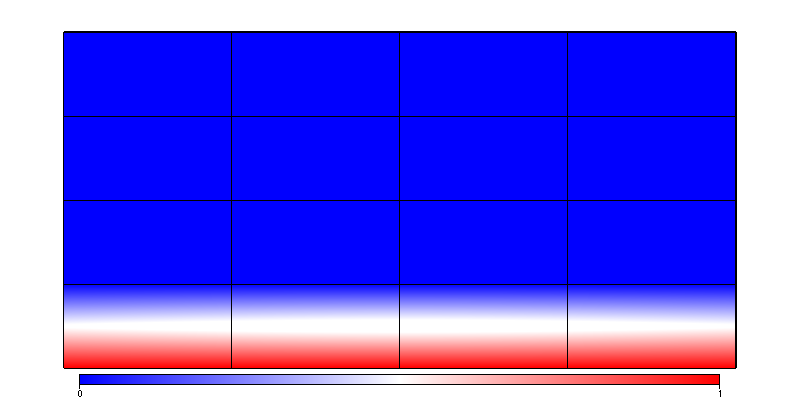

In [10]:
figtemp = plt.Figure(figsize=(800,400))
figtemp.Surface(temperatureField, temperatureMesh, colours="blue white red")
figtemp.Mesh(temperatureMesh, colourBar = False)
figtemp.show()

System setup
-----

**Setup a heat equation solver**

The steady state heat equation in is given by
\\[
\nabla(k\nabla)T = h
\\]
where $k$ is the conductivity, T is the temperature field (solved for) and $h$ is any additional heating term. See [here](https://en.wikipedia.org/wiki/Heat_equation) for more information on the heat equation.

To setup the heat equation using underworld the temperature field, conductivity and boundary conditions are passed to a system function (next cell). The system is then solved using the solve() method (see main loop below).

In [11]:
heatequation = uw.systems.SteadyStateHeat(temperatureField=temperatureField, conductivityFn=1.0, conditions=[tempBC,])

Solving
-----

Solving the heat equation system setup above is done by the following command.


In [12]:
heatequation.solve()

**Plot final temperature field**

The resulting temperature field has been loaded into the temperatureField variable. Let's visualise the results.

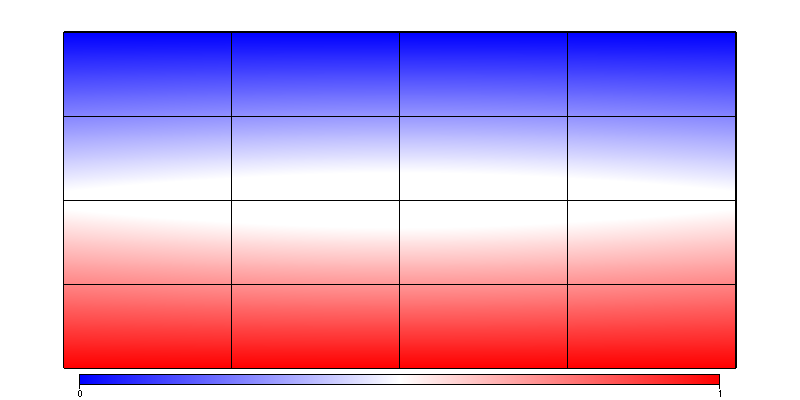

In [13]:
figtemp = plt.Figure(figsize=(800,400))
figtemp.Surface(temperatureField, temperatureMesh, colours="blue white red")
figtemp.Mesh(temperatureMesh, colourBar = False)
figtemp.show()